# Data Exploration - Varengold Bank AG Case Study

## Description

- explore raw data
- understand 
    1. structure
    2. relationships
    3. potential anomalies 

In [1]:
import pandas as pd
import duckdb
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


from dbt_case.data_exploration import (
    IDAnalyzer,
    DescriptiveStats,
    OutlierDetector,
    DataQualityAnalyzer,
    DataCleaner,
    Plotter,
    execute_query
)

In [2]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
from pathlib import Path
# Set up paths
NB_DIR = Path(os.curdir).resolve()
REPO_DIR = NB_DIR.parent
TRANS_DIR = REPO_DIR / 'transformation'
if not TRANS_DIR.exists():
    raise FileNotFoundError(f"Data directory {TRANS_DIR} does not exist. Please create it and add the required data files.")

DB_PATH = TRANS_DIR / "casestudy.duckdb"

# Set up visualization
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

## Connecting to the Database

In [3]:
# Connect to DuckDB database
conn = duckdb.connect(DB_PATH)

# Function to execute SQL queries and convert results to pandas DataFrames
def execute_query(query):
    return conn.execute(query).fetchdf()

## Exploring Available Tables and Schemas

In [4]:
# List all tables in the raw schema
tables_query = """SELECT table_name FROM information_schema.tables 
                  WHERE table_schema = 'raw' ORDER BY table_name"""
raw_tables = execute_query(tables_query)
print("Tables in raw schema:")
raw_tables

Tables in raw schema:


,table_name
0,accounts
1,customers
2,fx_rates
3,loans
4,transactions


## Exploring Tables Structure

In [5]:
# Function to get table schema
def get_table_schema(schema, table):
    query = f"""SELECT column_name, data_type, is_nullable 
                FROM information_schema.columns 
                WHERE table_schema = '{schema}' AND table_name = '{table}'
                ORDER BY ordinal_position"""
    return execute_query(query)

In [70]:
def get_all_column_names_in_schema(schema):
    query = f"""SELECT table_name, column_name 
                FROM information_schema.columns 
                WHERE table_schema = '{schema}' 
                ORDER BY table_name, ordinal_position"""
    return execute_query(query)

In [73]:
def starts_with_capital(string):
    """
    Check if a string starts with a capital letter.
    
    Args:
        string (str): The string to check
        
    Returns:
        bool: True if the string starts with a capital letter, False otherwise
    """
    if not string:  # Check if string is empty
        return False
    
    first_char = string[0]
    return first_char.isalpha() and first_char.isupper()


In [75]:
get_all_column_names_in_schema('raw').loc[lambda row: row["column_name"].map(lambda x: starts_with_capital(x))]


,table_name,column_name
7,customers,Age
8,customers,Gender
9,customers,Address
10,customers,City
11,customers,Contact Number
12,customers,Email
18,fx_rates,Column4


__SEE FINDINGS__


In [6]:
# Loop through tables and display schema
for idx, table in raw_tables.iterrows():
    table_name = table['table_name']
    print(f"\n----- Schema for raw.{table_name} -----")
    schema = get_table_schema('raw', table_name)
    display(schema)


----- Schema for raw.accounts -----


,column_name,data_type,is_nullable
0,account_id,INTEGER,YES
1,customer_id,INTEGER,YES
2,account_type,VARCHAR,YES
3,account_opening_date,VARCHAR,YES



----- Schema for raw.customers -----


,column_name,data_type,is_nullable
0,customer_id,INTEGER,YES
1,firstname,VARCHAR,YES
2,lastname,VARCHAR,YES
3,Age,INTEGER,YES
4,Gender,VARCHAR,YES
5,Address,VARCHAR,YES
6,City,VARCHAR,YES
7,Contact Number,BIGINT,YES
8,Email,VARCHAR,YES
9,creation_date,VARCHAR,YES



----- Schema for raw.fx_rates -----


,column_name,data_type,is_nullable
0,currency_iso_code,VARCHAR,YES
1,fx_rate,VARCHAR,YES
2,date,VARCHAR,YES
3,Column4,VARCHAR,YES



----- Schema for raw.loans -----


,column_name,data_type,is_nullable
0,customer_id,INTEGER,YES
1,loan_id,INTEGER,YES
2,loan_amount,VARCHAR,YES
3,loant_type,VARCHAR,YES
4,interest_rate,VARCHAR,YES
5,loan_term,INTEGER,YES
6,approval_rejection_date,VARCHAR,YES
7,loan_status,VARCHAR,YES



----- Schema for raw.transactions -----


,column_name,data_type,is_nullable
0,transaction_id,INTEGER,YES
1,transaction_date,VARCHAR,YES
2,account_id,INTEGER,YES
3,transaction_type,VARCHAR,YES
4,transaction_amount,VARCHAR,YES
5,transaction_currency,VARCHAR,YES


## Exploring Data in Each Table

In [7]:
# Function to get table data and basic stats
def explore_table(schema, table, limit=5):
    # Get sample data
    query = f"SELECT * FROM {schema}.{table} LIMIT {limit}"
    sample_data = execute_query(query)
    
    # Get row count
    count_query = f"SELECT COUNT(*) as row_count FROM {schema}.{table}"
    row_count = execute_query(count_query)['row_count'][0]
    
    print(f"\n----- Data Sample for {schema}.{table} (Total rows: {row_count}) -----")
    display(sample_data)
    
    return sample_data

In [8]:
# Explore each table
tables_data = {}
for idx, table in raw_tables.iterrows():
    table_name = table['table_name']
    tables_data[table_name] = explore_table('raw', table_name)


----- Data Sample for raw.accounts (Total rows: 5000) -----


,account_id,customer_id,account_type,account_opening_date
0,1,1,current,28.08.2024
1,2,2,current,25.03.2008
2,3,3,current,21.10.2017
3,4,4,savings,16.05.2016
4,5,5,savings,25.05.2024



----- Data Sample for raw.customers (Total rows: 10000) -----


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,14.06.2017,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,28.10.2016,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,08.09.2004,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,27.10.1995,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,14.06.2012,9



----- Data Sample for raw.fx_rates (Total rows: 15) -----


,currency_iso_code,fx_rate,date,Column4
0,USD,1,01.03.2023,
1,JPY,"159,39",01.03.2023,
2,BGN,2,01.03.2023,
3,CZK,25,01.03.2023,
4,DKK,7,01.03.2023,



----- Data Sample for raw.loans (Total rows: 5000) -----


,customer_id,loan_id,loan_amount,loant_type,interest_rate,loan_term,approval_rejection_date,loan_status
0,1,1,"32200,06",mortgage,"0,0119",36,05.11.2021,rejected
1,2,2,"47743,52",auto,"0,0297",36,7/30/2020,approved
2,3,3,"47981,31",auto,"0,0267",24,1/17/2021,closed
3,4,4,"4482,8",personal,"0,0019",48,2/15/2022,approved
4,5,5,"1092,33",mortgage,"0,0115",12,7/31/2020,approved



----- Data Sample for raw.transactions (Total rows: 56116) -----


,transaction_id,transaction_date,account_id,transaction_type,transaction_amount,transaction_currency
0,1000000,12.02.2025,3301,withdrawal,"1028,82",BGN
1,1000001,13.02.2025,82,withdrawal,"442,63",DKK
2,1000002,07.02.2025,1791,withdrawal,"5978,64",JPY
3,1000003,15.01.2025,1408,transfer,"8259,45",CHF
4,1000004,02.03.2025,4863,deposit,"7538,88",CZK


## Validation of Entity Relationships

__TODO__: Add here


## Individual Table Analysis

### Accounts Table




In [9]:
accounts_df = execute_query("SELECT * FROM raw.accounts")
accounts_df.head()


,account_id,customer_id,account_type,account_opening_date
0,1,1,current,28.08.2024
1,2,2,current,25.03.2008
2,3,3,current,21.10.2017
3,4,4,savings,16.05.2016
4,5,5,savings,25.05.2024


#### Check Data Quality


In [10]:
# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_accounts = DataQualityAnalyzer(accounts_df)
quality_analyzer_accounts.show_samples_with_cleaning(n_samples=3)


--- DATA QUALITY ANALYSIS ---

DataFrame shape: (5000, 4)
Data types:
account_id               int32
customer_id              int32
account_type            object
account_opening_date    object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
account_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

customer_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

account_type (object):
  1. Original: current
  2. Original: savings
  3. Original: 

account_opening_date (object):
  1. Original: 01.12.2008
     Cleaned date: 2008-12-01 (format: %d.%m.%Y)
  2. Original: 16.08.2010
     Cleaned date: 2010-08-16 (format: %d.%m.%Y)
  3. Original: 24.08.1999
     Cleaned date: 1999-08-24 (format: %d.%m.%Y)


Recommendations:
---------------
Columns that should be converted from mixed date formats: ['account_opening_date']


#### Clean Data



In [11]:
print("\n--- DATA CLEANING ---\n")
cleaner_accounts = DataCleaner(accounts_df)
cleaned_accounts_df = cleaner_accounts.clean_dataframe()

print(f"Before cleaning shape: {accounts_df.shape}")
print(f"After cleaning shape: {cleaned_accounts_df.shape}")
print("\nBefore cleaning dtypes:")
print(accounts_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_accounts_df.dtypes)


--- DATA CLEANING ---

Before cleaning shape: (5000, 4)
After cleaning shape: (5000, 4)

Before cleaning dtypes:
account_id               int32
customer_id              int32
account_type            object
account_opening_date    object
dtype: object

After cleaning dtypes:
account_id                       int32
customer_id                      int32
account_type                    object
account_opening_date    datetime64[ns]
dtype: object


#### ID Analysis


In [12]:
# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_accounts = IDAnalyzer(cleaned_accounts_df)
id_analysis_accounts = id_analyzer_accounts.check_id_duplicates(["account_id", "customer_id"])
id_analyzer_accounts.display_duplicate_analysis(analysis_results=id_analysis_accounts)

id_props = id_analyzer_accounts.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props['is_unique']}")
print(f"Is monotonic: {id_props['is_monotonic']}")


--- ID ANALYSIS ---

DataFrame Shape: (5000, 4)
--------------------------------------------------------------------------------

===== COLUMN: account_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COMPOSITE KEY ANALYSIS =====
Columns analyzed as composite key: account_id, customer_id
No duplicates found. These columns together form a unique composite key.
--------------------------------------------------------------------------------

Customer ID Properties:
Is unique: True
Is monotonic: True


In [13]:
digits_count = id_analyzer_accounts.count_digits_in_column('account_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



Digit counts in Contact Number:
account_id
4    4001
3     900
2      90
1       9
Name: count, dtype: int64


#### Descriptive Statistics

In [14]:
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_accounts = DescriptiveStats(cleaned_accounts_df)
stats_accounts = stats_analyzer_accounts.analyze_dataframe()
stats_analyzer_accounts.print_descriptive_stats(stats_accounts)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 4)
Total Missing Values: 3
--------------------------------------------------------------------------------

===== COLUMN: account_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: account_type (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 3 (0.06%)
Most Common: savings (2507 occurrences, 50.14%)

Top 5 values:
  - savings: 2507 occurrences
  - current: 2492 occurrenc

#### Outlier Detection


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 4)
Total Missing Values: 3
--------------------------------------------------------------------------------

===== COLUMN: account_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: account_type (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 3 (0.06% of total)
Most Common: savings (2507 occurrences, 50.14%)
Rare Categories: 1
Rare category values:
  - : 1 occurrences


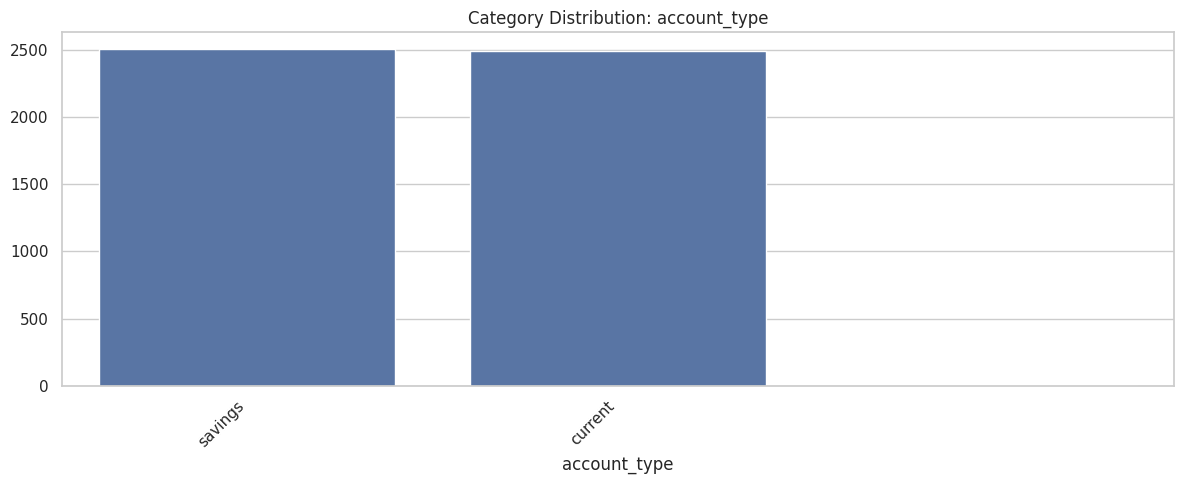

--------------------------------------------------------------------------------

===== COLUMN: account_opening_date (datetime64[ns]) =====
Count: 5000, Missing: 3 (0.06%)
Min Date: 1995-01-03 00:00:00
Max Date: 2024-12-22 00:00:00
Range: 10946 days


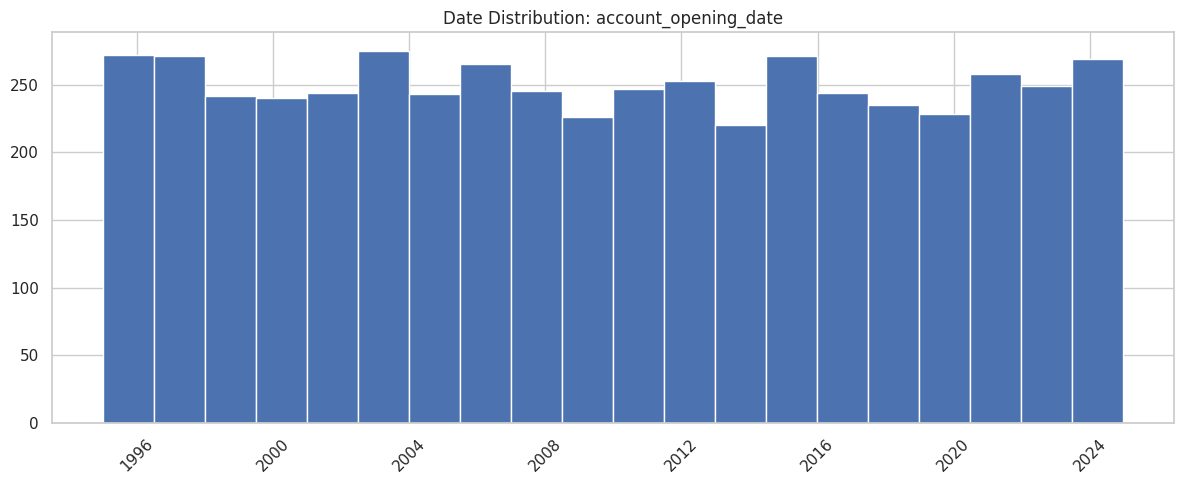

--------------------------------------------------------------------------------


In [19]:
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_accounts = OutlierDetector(cleaned_accounts_df)
outlier_results_accounts = outlier_detector_accounts.analyze_dataframe()
outlier_detector_accounts.display_outlier_analysis(outlier_results_accounts)

#### Plotting


--- PLOTTING EXAMPLES ---



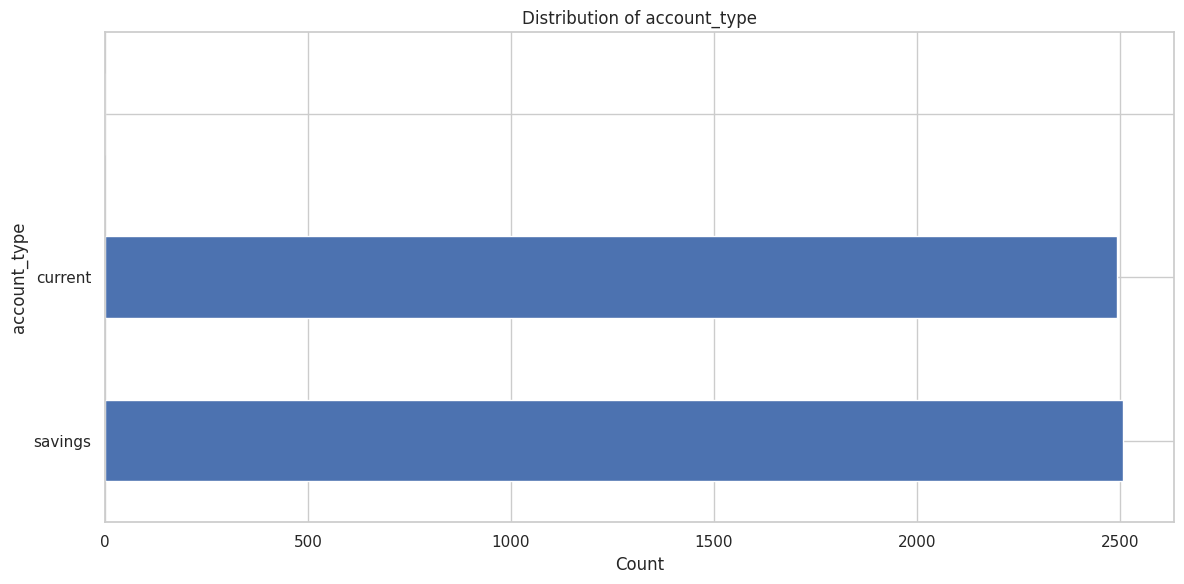

In [21]:
print("\n--- PLOTTING EXAMPLES ---\n")
plotter = Plotter(cleaned_accounts_df)

# Plot city distribution if available
plotter.plot_categorical_distribution('account_type', top_n=10)

### Customer Table




In [76]:
customers_df = execute_query("SELECT * FROM raw.customers")
customers_df.head()


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,14.06.2017,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,28.10.2016,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,08.09.2004,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,27.10.1995,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,14.06.2012,9


In [77]:

#### Check Data Quality

# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_customers = DataQualityAnalyzer(customers_df)
quality_analyzer_customers.show_samples_with_cleaning(n_samples=3)



--- DATA QUALITY ANALYSIS ---

DataFrame shape: (10000, 11)
Data types:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1253
  2. Original: 4685
  3. Original: 1732

firstname (object):
  1. Original: Sandra
  2. Original: Jennifer
  3. Original: Paul

lastname (object):
  1. Original: Kersten
  2. Original: Wahl
  3. Original: Mahler

Age (int32):
  1. Original: 53
  2. Original: 49
  3. Original: 78

Gender (object):
  1. Original: Male
  2. Original: Female
  3. Original: Other

Address (object):
  1. Original: Address_1253
  2. Original: Address_4685
  3. Original: Address_1732

City (object):
  1. Original:

In [78]:
customer_email_analysis_results = quality_analyzer_customers.analyze_emails(
    email_column='Email'
)

quality_analyzer_customers.print_email_analysis(customer_email_analysis_results)


Email Validation Results
Total emails analyzed: 10000
Null/missing emails: 0
Valid emails: 8918 (89.18%)
Invalid emails: 1082
Unique domains found: 7

Top 10 Most Common Domains:
  gmx.net: 1342 emails
  posteo.de: 1326 emails
  aol.com: 1272 emails
  googlemail.com: 1268 emails
  outlook.com: 1262 emails
  web.de: 1228 emails
  yahoo.com: 1220 emails

Common Error Types:
  Username contains invalid characters: 1082 emails

Examples of Invalid Emails:
  Index 8: daniel.weiß@gmx.net - Username contains invalid characters
  Index 21: donna.könig@web.de - Username contains invalid characters
  Index 49: sandra.bär@posteo.de - Username contains invalid characters
  Index 53: timothy.rösler@outlook.com - Username contains invalid characters
  Index 76: susan.heß@googlemail.com - Username contains invalid characters
  Index 81: susan.schütze@outlook.com - Username contains invalid characters
  Index 124: daniel.köhn@posteo.de - Username contains invalid characters
  Index 129: michelle.dörr@

In [79]:
#### Clean Data

print("\n--- DATA CLEANING ---\n")
cleaner_customers = DataCleaner(customers_df)
cleaned_customers_df = cleaner_customers.clean_dataframe()


print(f"Before cleaning shape: {customers_df.shape}")
print(f"After cleaning shape: {cleaned_customers_df.shape}")
print("\nBefore cleaning dtypes:")
print(customers_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_customers_df.dtypes)



--- DATA CLEANING ---

Before cleaning shape: (10000, 11)
After cleaning shape: (10000, 11)

Before cleaning dtypes:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

After cleaning dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object


In [80]:
#### ID Analysis

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_customers = IDAnalyzer(cleaned_customers_df)
id_analysis_customers = id_analyzer_customers.check_id_duplicates(["customer_id", "Address"])
id_analyzer_customers.display_duplicate_analysis(analysis_results=id_analysis_customers)

id_props_cust = id_analyzer_customers.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")


--- ID ANALYSIS ---

DataFrame Shape: (10000, 11)
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
DUPLICATES FOUND: 5000 distinct values are duplicated
Total records with duplicate values: 10000

Duplicate values (value: count):
  - 5000: 2 occurrences
  - 1: 2 occurrences
  - 2: 2 occurrences
  - 3: 2 occurrences
  - 4: 2 occurrences
  - 5: 2 occurrences
  - 6: 2 occurrences
  - 7: 2 occurrences
  - 4984: 2 occurrences
  - 4983: 2 occurrences
  - 4982: 2 occurrences
  - 4981: 2 occurrences
  - 4980: 2 occurrences
  - 4979: 2 occurrences
  - 4978: 2 occurrences
  - 4977: 2 occurrences
  - 4976: 2 occurrences
  - 4975: 2 occurrences
  - 4974: 2 occurrences
  - 4973: 2 occurrences
  - 4972: 2 occurrences
  - 4971: 2 occurrences
  - 4970: 2 occurrences
  - 4969: 2 occurrences
  - 40: 2 occurrences
  - 39: 2 occurrences
  - 38: 2 occurrences
  - 37: 2 occurrences
  - 36: 2 occurrences
  - 35: 2 occ

In [81]:
digits_count = id_analyzer_customers.count_digits_in_column('customer_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



Digit counts in Contact Number:
customer_id
4    8002
3    1800
2     180
1      18
Name: count, dtype: int64


In [82]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 10]


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
9,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30
5009,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30


In [83]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 20]

,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
19,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61
5019,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61


In [84]:
# print shape before dropping duplicates
print(f"Before dropping duplicates shape: {cleaned_customers_df.shape}")
# dropping duplicates
cleaned_customers_df = cleaned_customers_df.drop_duplicates(subset=['customer_id'], keep='last')
print(f"After dropping duplicates shape: {cleaned_customers_df.shape}")
print("\nAfter dropping duplicates dtypes:")
print(cleaned_customers_df.dtypes)
# Check if duplicates are removed
duplicates_after = cleaned_customers_df.duplicated(subset=['customer_id']).sum()
print(f"Duplicates after removal: {duplicates_after}")

Before dropping duplicates shape: (10000, 11)
After dropping duplicates shape: (5000, 11)

After dropping duplicates dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object
Duplicates after removal: 0


In [85]:
#### Descriptive Statistics
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_customers = DescriptiveStats(cleaned_customers_df)
stats_customers = stats_analyzer_customers.analyze_dataframe()
stats_analyzer_customers.print_descriptive_stats(stats_customers)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00%)
Most Common: Timothy (124 occurrences, 2.48%)

Top 5 values:
  - Timothy: 124 occurrences
  - Ronald: 123 occurrences
  - Andrew: 117 occurrences
  - Charles: 115 occurrences
  - Betty: 114 occurrences
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92%)
Most Common: Schütt (13 occurrences, 0.26%)

T


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00% of total)
Most Common: Timothy (124 occurrences, 2.48%)
Rare Categories: 25
25 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92% of total)
Most Common: Schütt (13 occurrences, 0.26%)
Rare Categories: 996
996 rare categories found
-----------------------------------------------------------

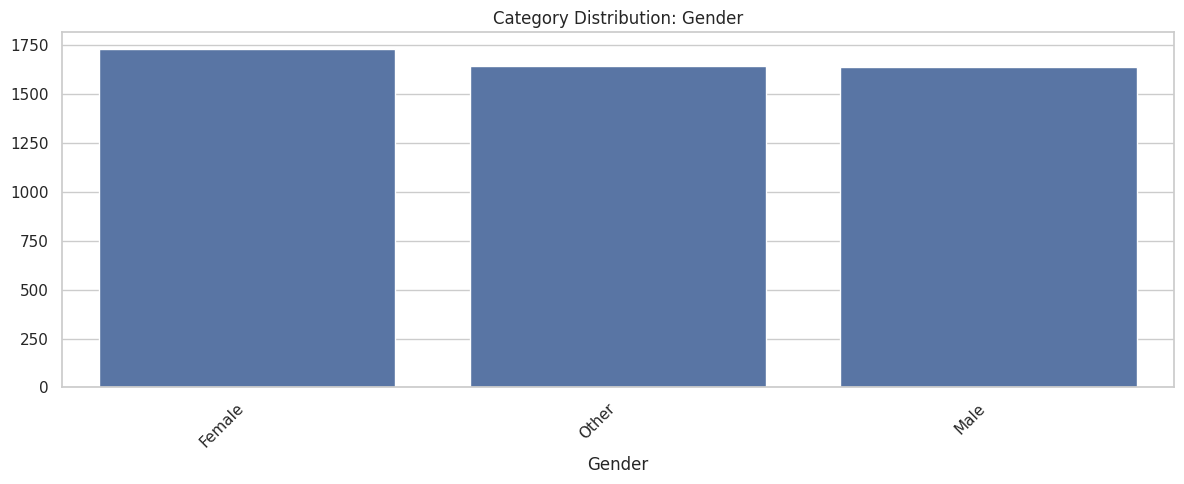

--------------------------------------------------------------------------------

===== COLUMN: Address (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00% of total)
Most Common: Address_5000 (1 occurrences, 0.02%)
Rare Categories: 5000
5000 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: City (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 40 (0.80% of total)
Most Common: San Jose (163 occurrences, 3.26%)
Rare Categories: 20
20 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: Contact Number (int64) =====
Count: 5000, Missing: 0 (0.00%)
Min: 49037065, Max: 490999756607
Mean: 408144494563.85, Median: 490440032285.50, Std: 173667729681.33
Skewness: -1.64
Outliers (IQR method): 920 (18.40%)
Outliers (Z-score method): 0 (0.00%)
920 outliers found


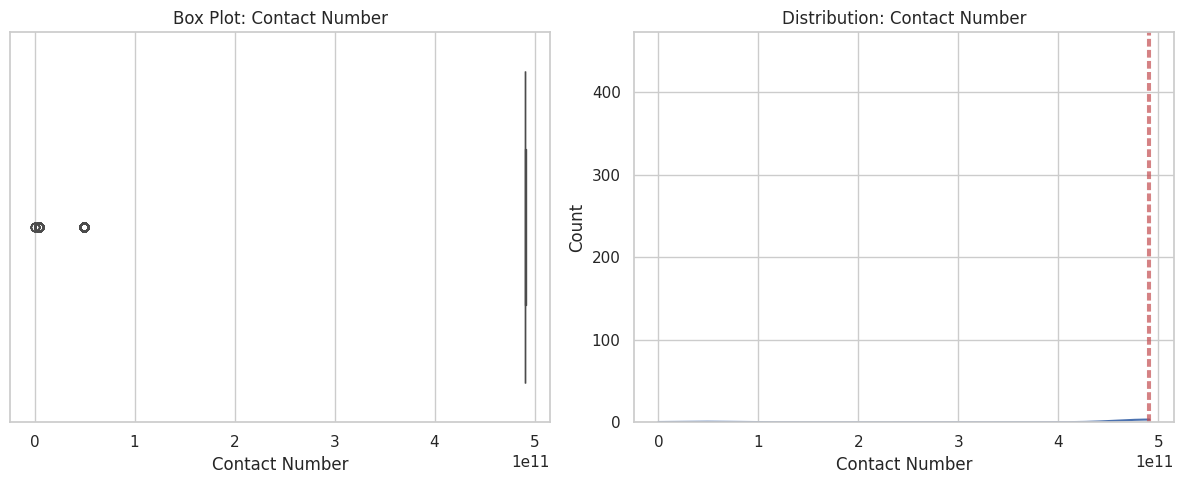

--------------------------------------------------------------------------------

===== COLUMN: Email (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 4944 (98.88% of total)
Most Common: kenneth.rudolf@gmx.net (2 occurrences, 0.04%)
Rare Categories: 4944
4944 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: creation_date (datetime64[ns]) =====
Count: 5000, Missing: 0 (0.00%)
Min Date: 1995-01-02 00:00:00
Max Date: 2024-12-28 00:00:00
Range: 10953 days


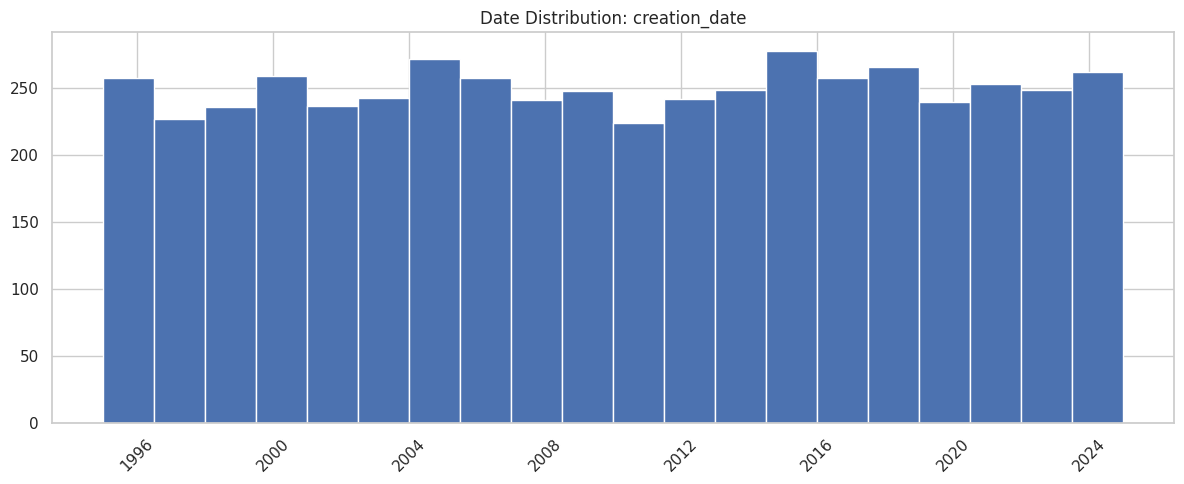

--------------------------------------------------------------------------------

===== COLUMN: branch_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 99
Mean: 50.59, Median: 50.00, Std: 28.50
Skewness: -0.01
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------


In [86]:
##### Outlier Detection
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_customers = OutlierDetector(cleaned_customers_df)
outlier_results_customers = outlier_detector_customers.analyze_dataframe()
outlier_detector_customers.display_outlier_analysis(outlier_results_customers)


In [46]:
cleaned_customers_df.columns


Index(['customer_id', 'firstname', 'lastname', 'Age', 'Gender', 'Address',
       'City', 'Contact Number', 'Email', 'creation_date', 'branch_id'],
      dtype='object')

In [87]:
cleaned_customers_df.loc[lambda x: x['Email'] == "kenneth.rudolf@gmx.net"]


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
5787,788,Kenneth,Rudolf,52,Male,Address_788,Austin,490794413570,kenneth.rudolf@gmx.net,2010-07-06,21
9693,4694,Kenneth,Rudolf,48,Male,Address_4694,Austin,490927229298,kenneth.rudolf@gmx.net,2005-01-06,74


In [102]:
# Get all rows where the email appears more than once
duplicate_emails_df = cleaned_customers_df[cleaned_customers_df["Email"].duplicated(keep=False)]

# Sort by email to group duplicates together
duplicate_emails_df = duplicate_emails_df.sort_values("Email")

duplicate_emails_df


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
6570,1571,Andrew,Heil,28,Other,Address_1571,Nashville,490529759730,andrew.heil@gmx.net,1996-08-13,21
7637,2638,Andrew,Heil,59,Other,Address_2638,Oklahoma City,490242559267,andrew.heil@gmx.net,2005-12-12,63
5353,354,Andrew,Schröter,19,Other,Address_354,Portland,490603644749,andrew.schröter@posteo.de,2008-12-26,10
8089,3090,Andrew,Schröter,64,Male,Address_3090,Columbus,490104731279,andrew.schröter@posteo.de,2001-04-03,10
5358,359,Ashley,Ebner,77,Female,Address_359,Dallas,490541267315,ashley.ebner@gmx.net,2024-10-21,55
...,...,...,...,...,...,...,...,...,...,...,...
6308,1309,Susan,Ziegler,45,Other,Address_1309,Tucson,490186389068,susan.ziegler@outlook.com,2009-12-10,54
6089,1090,William,Dietrich,32,Female,Address_1090,Tucson,490783883261,william.dietrich@posteo.de,2023-08-26,71
6866,1867,William,Dietrich,25,Other,Address_1867,Las Vegas,490391660417,william.dietrich@posteo.de,1996-06-16,35
8591,3592,William,Reiter,71,Female,Address_3592,Nashville,490971569670,william.reiter@gmx.net,2007-01-27,42



--- PLOTTING EXAMPLES ---



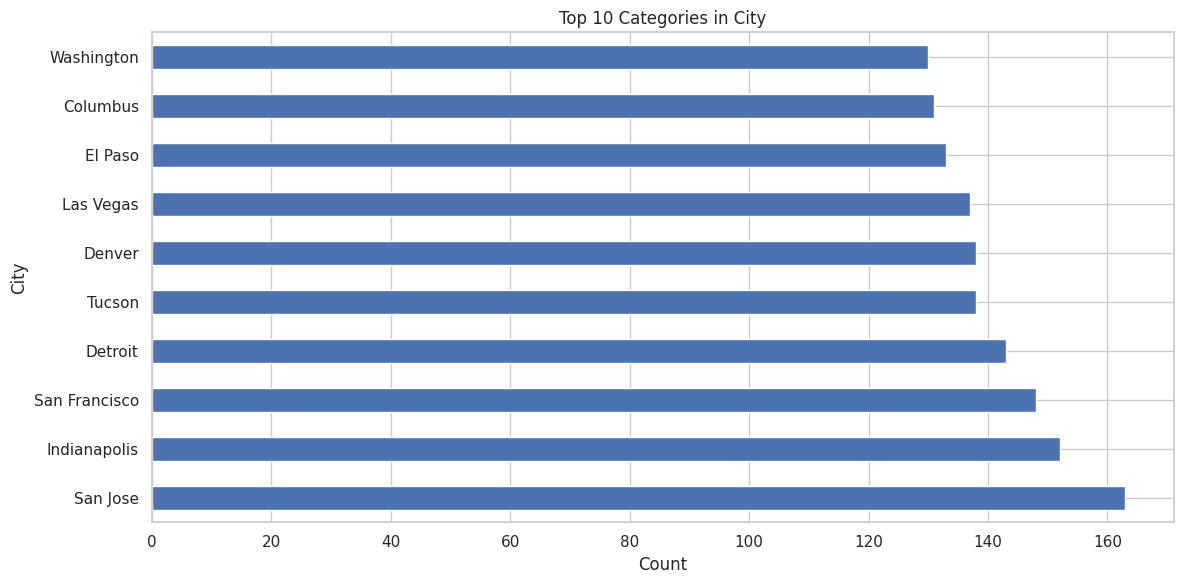

In [49]:
#### Plotting
print("\n--- PLOTTING EXAMPLES ---\n")
plotter = Plotter(cleaned_customers_df)

# Plot city distribution if available
plotter.plot_categorical_distribution('City', top_n=10)

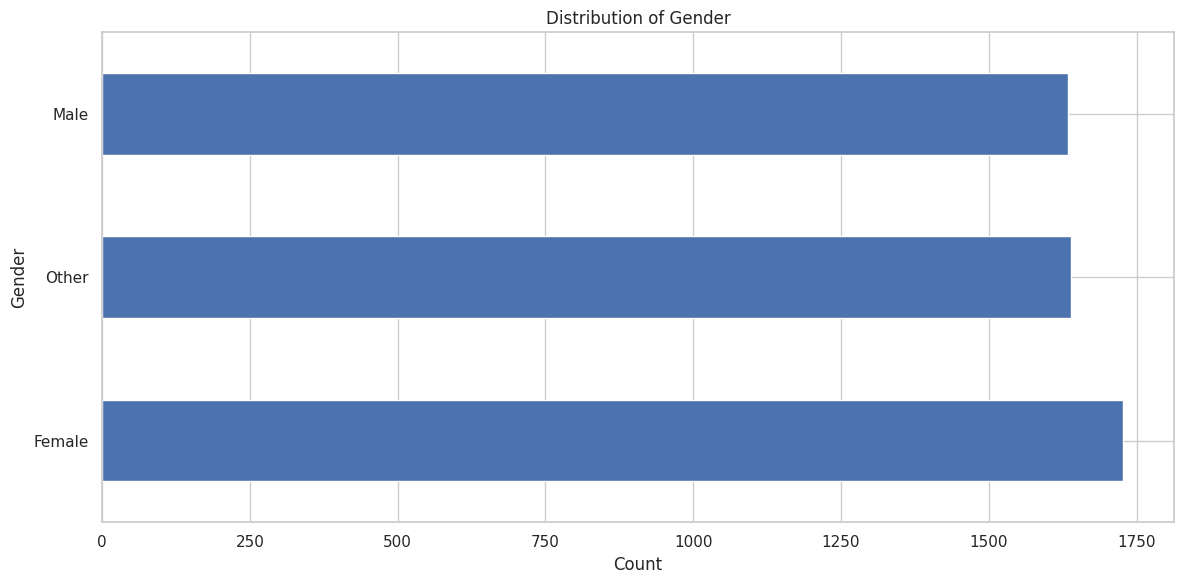

In [50]:
plotter.plot_categorical_distribution('Gender', top_n=10)

In [59]:
cleaned_customers_df.groupby(["Address", "City"])["Address"].agg("count").describe()


count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: Address, dtype: float64

In [ ]:
customers_df = execute_query("SELECT * FROM raw.customers")
customers_df.head()


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,14.06.2017,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,28.10.2016,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,08.09.2004,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,27.10.1995,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,14.06.2012,9


In [ ]:

#### Check Data Quality

# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_customers = DataQualityAnalyzer(customers_df)
quality_analyzer_customers.show_samples_with_cleaning(n_samples=3)



--- DATA QUALITY ANALYSIS ---

DataFrame shape: (10000, 11)
Data types:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1253
  2. Original: 4685
  3. Original: 1732

firstname (object):
  1. Original: Sandra
  2. Original: Jennifer
  3. Original: Paul

lastname (object):
  1. Original: Kersten
  2. Original: Wahl
  3. Original: Mahler

Age (int32):
  1. Original: 53
  2. Original: 49
  3. Original: 78

Gender (object):
  1. Original: Male
  2. Original: Female
  3. Original: Other

Address (object):
  1. Original: Address_1253
  2. Original: Address_4685
  3. Original: Address_1732

City (object):
  1. Original:

In [ ]:
customer_email_analysis_results = quality_analyzer_customers.analyze_emails(
    email_column='Email'
)

quality_analyzer_customers.print_email_analysis(customer_email_analysis_results)


Email Validation Results
Total emails analyzed: 10000
Null/missing emails: 0
Valid emails: 8918 (89.18%)
Invalid emails: 1082
Unique domains found: 7

Top 10 Most Common Domains:
  gmx.net: 1342 emails
  posteo.de: 1326 emails
  aol.com: 1272 emails
  googlemail.com: 1268 emails
  outlook.com: 1262 emails
  web.de: 1228 emails
  yahoo.com: 1220 emails

Common Error Types:
  Username contains invalid characters: 1082 emails

Examples of Invalid Emails:
  Index 8: daniel.weiß@gmx.net - Username contains invalid characters
  Index 21: donna.könig@web.de - Username contains invalid characters
  Index 49: sandra.bär@posteo.de - Username contains invalid characters
  Index 53: timothy.rösler@outlook.com - Username contains invalid characters
  Index 76: susan.heß@googlemail.com - Username contains invalid characters
  Index 81: susan.schütze@outlook.com - Username contains invalid characters
  Index 124: daniel.köhn@posteo.de - Username contains invalid characters
  Index 129: michelle.dörr@

In [ ]:
#### Clean Data

print("\n--- DATA CLEANING ---\n")
cleaner_customers = DataCleaner(customers_df)
cleaned_customers_df = cleaner_customers.clean_dataframe()


print(f"Before cleaning shape: {customers_df.shape}")
print(f"After cleaning shape: {cleaned_customers_df.shape}")
print("\nBefore cleaning dtypes:")
print(customers_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_customers_df.dtypes)



--- DATA CLEANING ---

Before cleaning shape: (10000, 11)
After cleaning shape: (10000, 11)

Before cleaning dtypes:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

After cleaning dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object


In [ ]:
#### ID Analysis

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_customers = IDAnalyzer(cleaned_customers_df)
id_analysis_customers = id_analyzer_customers.check_id_duplicates(["customer_id", "Address"])
id_analyzer_customers.display_duplicate_analysis(analysis_results=id_analysis_customers)

id_props_cust = id_analyzer_customers.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")


--- ID ANALYSIS ---

DataFrame Shape: (5000, 11)
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COLUMN: Address =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COMPOSITE KEY ANALYSIS =====
Columns analyzed as composite key: customer_id, Address
No duplicates found. These columns together form a unique composite key.
--------------------------------------------------------------------------------

Customer ID Properties:
Is unique: True
Is monotonic: True


In [ ]:
digits_count = id_analyzer_customers.count_digits_in_column('customer_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



Digit counts in Contact Number:
customer_id
4    8002
3    1800
2     180
1      18
Name: count, dtype: int64


In [ ]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 10]


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
9,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30
5009,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30


In [ ]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 20]

,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
19,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61
5019,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61


In [ ]:
# print shape before dropping duplicates
print(f"Before dropping duplicates shape: {cleaned_customers_df.shape}")
# dropping duplicates
cleaned_customers_df = cleaned_customers_df.drop_duplicates(subset=['customer_id'], keep='last')
print(f"After dropping duplicates shape: {cleaned_customers_df.shape}")
print("\nAfter dropping duplicates dtypes:")
print(cleaned_customers_df.dtypes)
# Check if duplicates are removed
duplicates_after = cleaned_customers_df.duplicated(subset=['customer_id']).sum()
print(f"Duplicates after removal: {duplicates_after}")


Before dropping duplicates shape: (10000, 11)
After dropping duplicates shape: (5000, 11)

After dropping duplicates dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object
Duplicates after removal: 0


In [ ]:
#### Descriptive Statistics
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_customers = DescriptiveStats(cleaned_customers_df)
stats_customers = stats_analyzer_customers.analyze_dataframe()
stats_analyzer_customers.print_descriptive_stats(stats_customers)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00%)
Most Common: Timothy (124 occurrences, 2.48%)

Top 5 values:
  - Timothy: 124 occurrences
  - Ronald: 123 occurrences
  - Andrew: 117 occurrences
  - Charles: 115 occurrences
  - Betty: 114 occurrences
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92%)
Most Common: Schütt (13 occurrences, 0.26%)

T


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00% of total)
Most Common: Timothy (124 occurrences, 2.48%)
Rare Categories: 25
25 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92% of total)
Most Common: Schütt (13 occurrences, 0.26%)
Rare Categories: 996
996 rare categories found
-----------------------------------------------------------

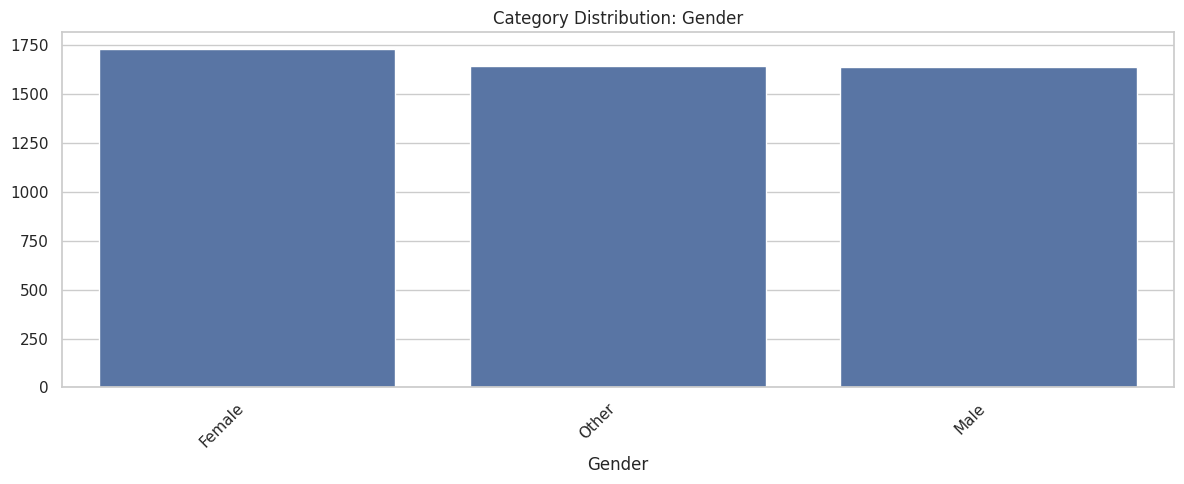

--------------------------------------------------------------------------------

===== COLUMN: Address (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00% of total)
Most Common: Address_5000 (1 occurrences, 0.02%)
Rare Categories: 5000
5000 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: City (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 40 (0.80% of total)
Most Common: San Jose (163 occurrences, 3.26%)
Rare Categories: 20
20 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: Contact Number (int64) =====
Count: 5000, Missing: 0 (0.00%)
Min: 49037065, Max: 490999756607
Mean: 408144494563.85, Median: 490440032285.50, Std: 173667729681.33
Skewness: -1.64
Outliers (IQR method): 920 (18.40%)
Outliers (Z-score method): 0 (0.00%)
920 outliers found


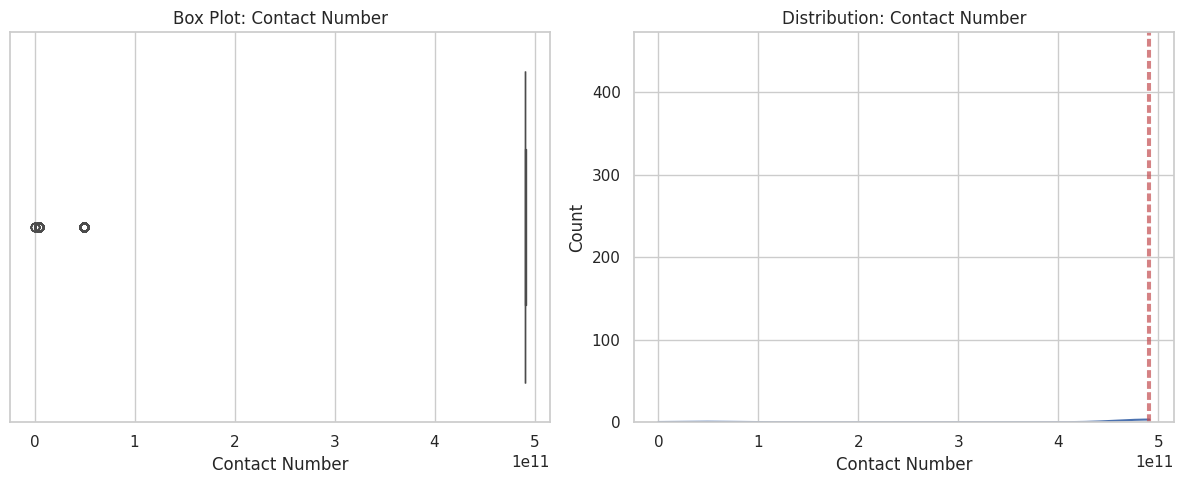

--------------------------------------------------------------------------------

===== COLUMN: Email (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 4944 (98.88% of total)
Most Common: kenneth.rudolf@gmx.net (2 occurrences, 0.04%)
Rare Categories: 4944
4944 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: creation_date (datetime64[ns]) =====
Count: 5000, Missing: 0 (0.00%)
Min Date: 1995-01-02 00:00:00
Max Date: 2024-12-28 00:00:00
Range: 10953 days


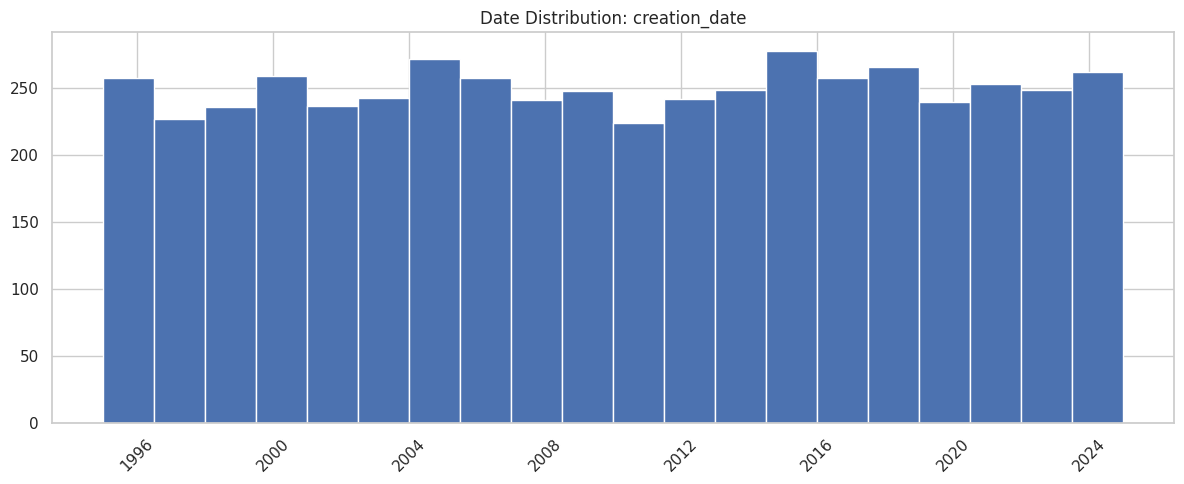

--------------------------------------------------------------------------------

===== COLUMN: branch_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 99
Mean: 50.59, Median: 50.00, Std: 28.50
Skewness: -0.01
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------


In [ ]:
##### Outlier Detection
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_customers = OutlierDetector(cleaned_customers_df)
outlier_results_customers = outlier_detector_customers.analyze_dataframe()
outlier_detector_customers.display_outlier_analysis(outlier_results_customers)


In [ ]:
cleaned_customers_df.columns


Index(['customer_id', 'firstname', 'lastname', 'Age', 'Gender', 'Address',
       'City', 'Contact Number', 'Email', 'creation_date', 'branch_id'],
      dtype='object')


--- PLOTTING EXAMPLES ---



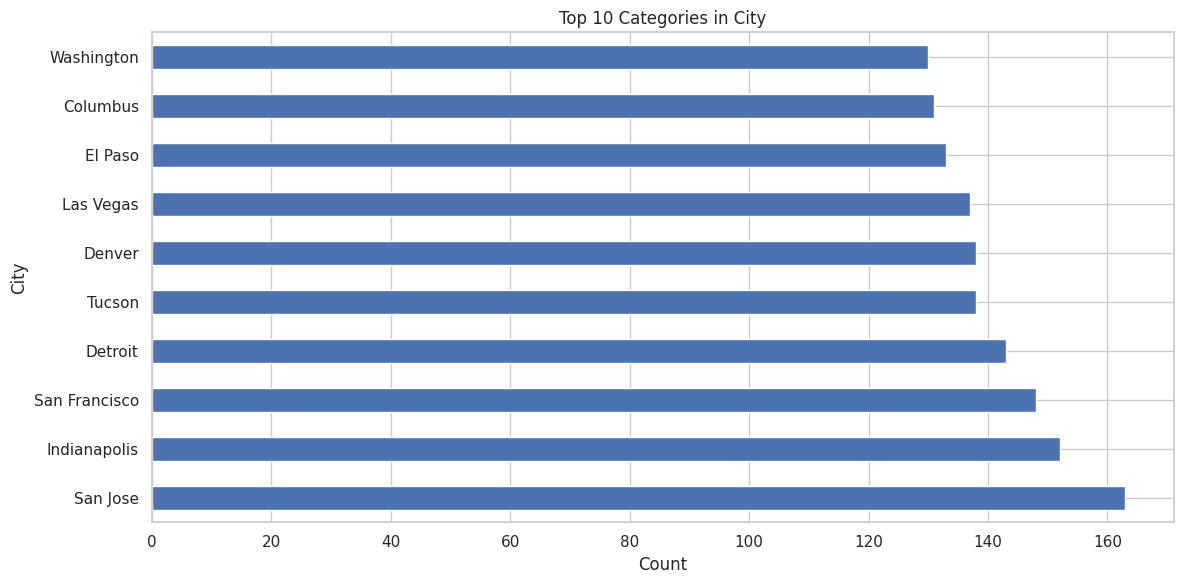

In [ ]:
#### Plotting
print("\n--- PLOTTING EXAMPLES ---\n")
plotter = Plotter(cleaned_customers_df)

# Plot city distribution if available
plotter.plot_categorical_distribution('City', top_n=10)

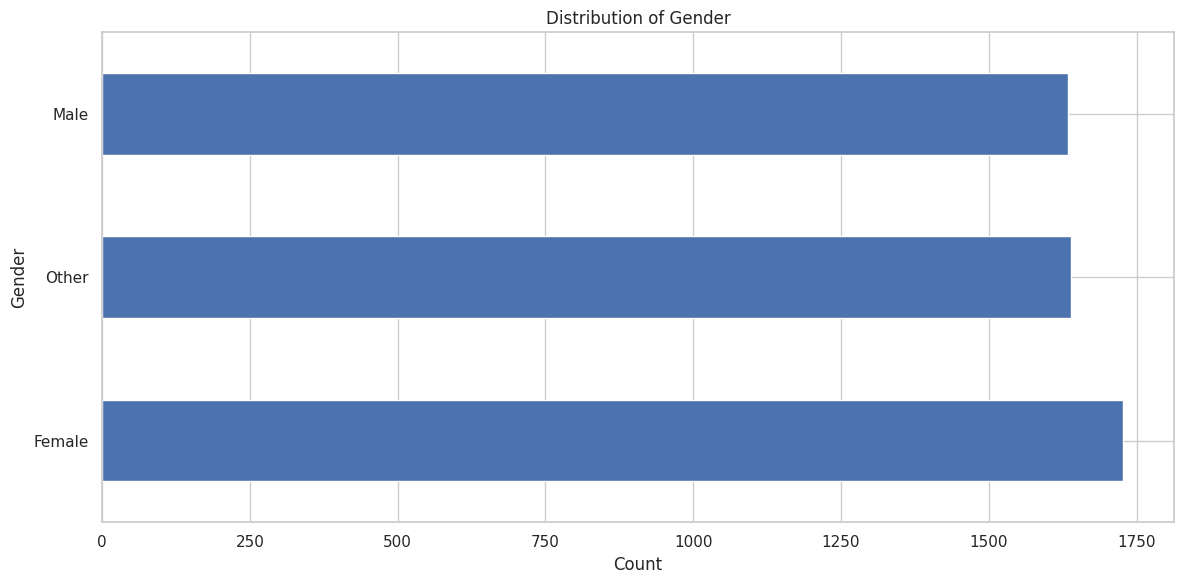

In [ ]:
plotter.plot_categorical_distribution('Gender', top_n=10)

In [ ]:
cleaned_customers_df.groupby(["Address", "City"])["Address"].agg("count").describe()


count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: Address, dtype: float64

### Loans Table




In [60]:
loans_df = execute_query("SELECT * FROM raw.loans")
loans_df.head()



,customer_id,loan_id,loan_amount,loant_type,interest_rate,loan_term,approval_rejection_date,loan_status
0,1,1,"32200,06",mortgage,"0,0119",36,05.11.2021,rejected
1,2,2,"47743,52",auto,"0,0297",36,7/30/2020,approved
2,3,3,"47981,31",auto,"0,0267",24,1/17/2021,closed
3,4,4,"4482,8",personal,"0,0019",48,2/15/2022,approved
4,5,5,"1092,33",mortgage,"0,0115",12,7/31/2020,approved


In [61]:

#### Check Data Quality

# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_loans = DataQualityAnalyzer(loans_df)
quality_analyzer_loans.show_samples_with_cleaning(n_samples=3)




--- DATA QUALITY ANALYSIS ---

DataFrame shape: (5000, 8)
Data types:
customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

loan_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

loan_amount (object):
  1. Original: 29149,52
     Cleaned numeric: 29149.52
  2. Original: 48965,54
     Cleaned numeric: 48965.54
  3. Original: 12395,31
     Cleaned numeric: 12395.31

loant_type (object):
  1. Original: mortgage
  2. Original: auto
  3. Original: personal

interest_rate (object):
  1. Original: 0,0176
     Cleaned numeric: 0.0176
  2. Original: 0,0490
     

In [62]:

#### Clean Data

print("\n--- DATA CLEANING ---\n")
cleaner_loans = DataCleaner(loans_df)
cleaned_loans_df = cleaner_loans.clean_dataframe()


print(f"Before cleaning shape: {loans_df.shape}")
print(f"After cleaning shape: {cleaned_loans_df.shape}")
print("\nBefore cleaning dtypes:")
print(loans_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_loans_df.dtypes)



--- DATA CLEANING ---

Before cleaning shape: (5000, 8)
After cleaning shape: (5000, 8)

Before cleaning dtypes:
customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

After cleaning dtypes:
customer_id                         int32
loan_id                             int32
loan_amount                       float64
loant_type                         object
interest_rate                     float64
loan_term                           int32
approval_rejection_date    datetime64[ns]
loan_status                        object
dtype: object


In [66]:

#### ID Analysis

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_loans = IDAnalyzer(cleaned_loans_df)
id_analysis_loans = id_analyzer_loans.check_id_duplicates(["loan_id", "customer_id"])
id_analyzer_loans.display_duplicate_analysis(analysis_results=id_analysis_loans)

id_props_cust = id_analyzer_loans.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")

id_props_loan = id_analyzer_loans.check_id_properties('loan_id')
print("\nLoan ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")
digits_count = id_analyzer_loans.count_digits_in_column('customer_id')



--- ID ANALYSIS ---

DataFrame Shape: (5000, 8)
--------------------------------------------------------------------------------

===== COLUMN: loan_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COMPOSITE KEY ANALYSIS =====
Columns analyzed as composite key: loan_id, customer_id
No duplicates found. These columns together form a unique composite key.
--------------------------------------------------------------------------------

Customer ID Properties:
Is unique: True
Is monotonic: True

Loan ID Properties:
Is unique: True
Is monotonic: True


In [67]:
#### Descriptive Statistics
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_loans = DescriptiveStats(cleaned_loans_df)
stats_loans = stats_analyzer_loans.analyze_dataframe()
stats_analyzer_loans.print_descriptive_stats(stats_loans)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 8)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: loan_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: loan_amount (float64) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1006.37, Max: 49993.49
Mean: 25501.04, Median: 25909.71, Std: 14039.73
Skewness: -0.02
Quartiles: Q1=13315.31, Q2

In [ ]:

##### Outlier Detection
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_loans = OutlierDetector(cleaned_loans_df)
outlier_results_loans = outlier_detector_loans.analyze_dataframe()
outlier_detector_loans.display_outlier_analysis(outlier_results_loans)

cleaned_loans_df.columns

#### Plotting
print("\n--- PLOTTING EXAMPLES ---\n")
plotter = Plotter(cleaned_loans_df)

# Plot city distribution if available
plotter.plot_categorical_distribution('City', top_n=10)
plotter.plot_categorical_distribution('Gender', top_n=10)
cleaned_loans_df.groupby(["Address", "City"])["Address"].agg("count").describe()


loans_df = execute_query("SELECT * FROM raw.loans")
loans_df.head()


#### Check Data Quality

# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_loans = DataQualityAnalyzer(loans_df)
quality_analyzer_loans.show_samples_with_cleaning(n_samples=3)

customer_email_analysis_results = quality_analyzer_loans.analyze_emails(
    email_column='Email'
)

quality_analyzer_loans.print_email_analysis(customer_email_analysis_results)

#### Clean Data

print("\n--- DATA CLEANING ---\n")
cleaner_loans = DataCleaner(loans_df)
cleaned_loans_df = cleaner_loans.clean_dataframe()


print(f"Before cleaning shape: {loans_df.shape}")
print(f"After cleaning shape: {cleaned_loans_df.shape}")
print("\nBefore cleaning dtypes:")
print(loans_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_loans_df.dtypes)

#### ID Analysis

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_loans = IDAnalyzer(cleaned_loans_df)
id_analysis_loans = id_analyzer_loans.check_id_duplicates(["customer_id", "Address"])
id_analyzer_loans.display_duplicate_analysis(analysis_results=id_analysis_loans)

id_props_cust = id_analyzer_loans.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")

In [ ]:
digits_count = id_analyzer_customers.count_digits_in_column('customer_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



Digit counts in Contact Number:
customer_id
4    8002
3    1800
2     180
1      18
Name: count, dtype: int64


In [ ]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 10]


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
9,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30
5009,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30


In [ ]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 20]

,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
19,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61
5019,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61


In [ ]:
# print shape before dropping duplicates
print(f"Before dropping duplicates shape: {cleaned_customers_df.shape}")
# dropping duplicates
cleaned_customers_df = cleaned_customers_df.drop_duplicates(subset=['customer_id'], keep='last')
print(f"After dropping duplicates shape: {cleaned_customers_df.shape}")
print("\nAfter dropping duplicates dtypes:")
print(cleaned_customers_df.dtypes)
# Check if duplicates are removed
duplicates_after = cleaned_customers_df.duplicated(subset=['customer_id']).sum()
print(f"Duplicates after removal: {duplicates_after}")


Before dropping duplicates shape: (10000, 11)
After dropping duplicates shape: (5000, 11)

After dropping duplicates dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object
Duplicates after removal: 0


In [ ]:
#### Descriptive Statistics
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_customers = DescriptiveStats(cleaned_customers_df)
stats_customers = stats_analyzer_customers.analyze_dataframe()
stats_analyzer_customers.print_descriptive_stats(stats_customers)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00%)
Most Common: Timothy (124 occurrences, 2.48%)

Top 5 values:
  - Timothy: 124 occurrences
  - Ronald: 123 occurrences
  - Andrew: 117 occurrences
  - Charles: 115 occurrences
  - Betty: 114 occurrences
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92%)
Most Common: Schütt (13 occurrences, 0.26%)

T


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00% of total)
Most Common: Timothy (124 occurrences, 2.48%)
Rare Categories: 25
25 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92% of total)
Most Common: Schütt (13 occurrences, 0.26%)
Rare Categories: 996
996 rare categories found
-----------------------------------------------------------

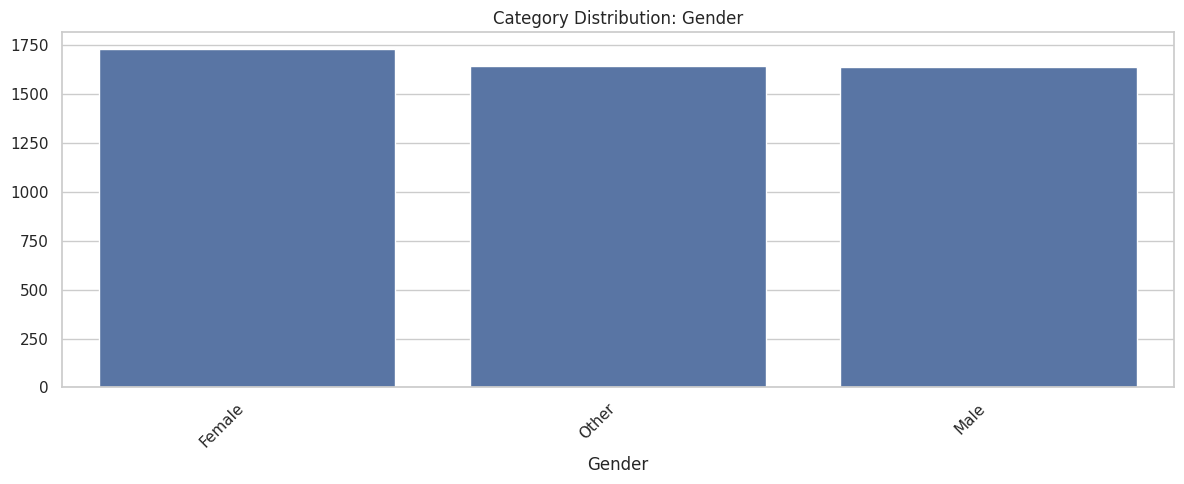

--------------------------------------------------------------------------------

===== COLUMN: Address (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00% of total)
Most Common: Address_5000 (1 occurrences, 0.02%)
Rare Categories: 5000
5000 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: City (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 40 (0.80% of total)
Most Common: San Jose (163 occurrences, 3.26%)
Rare Categories: 20
20 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: Contact Number (int64) =====
Count: 5000, Missing: 0 (0.00%)
Min: 49037065, Max: 490999756607
Mean: 408144494563.85, Median: 490440032285.50, Std: 173667729681.33
Skewness: -1.64
Outliers (IQR method): 920 (18.40%)
Outliers (Z-score method): 0 (0.00%)
920 outliers found


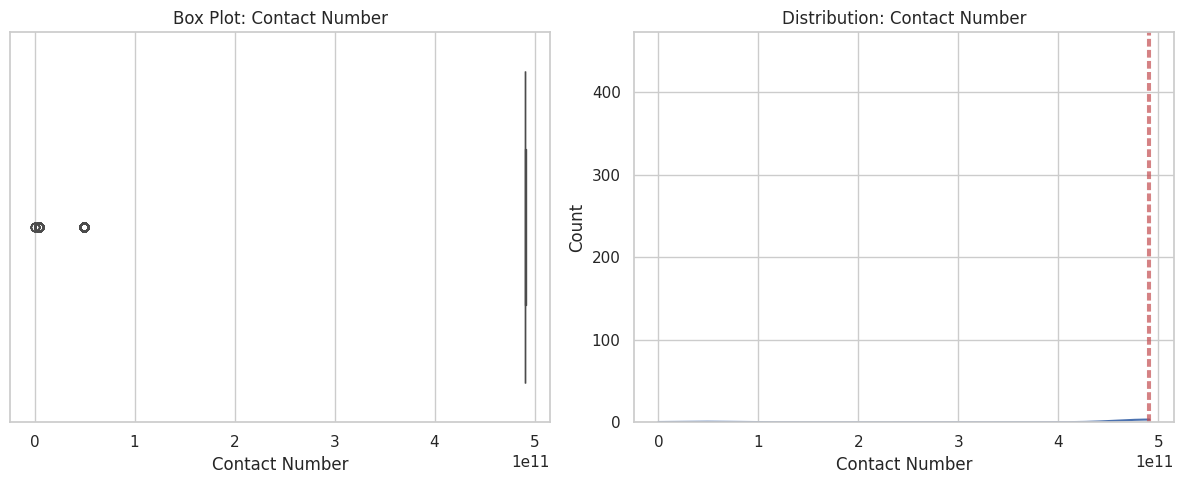

--------------------------------------------------------------------------------

===== COLUMN: Email (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 4944 (98.88% of total)
Most Common: kenneth.rudolf@gmx.net (2 occurrences, 0.04%)
Rare Categories: 4944
4944 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: creation_date (datetime64[ns]) =====
Count: 5000, Missing: 0 (0.00%)
Min Date: 1995-01-02 00:00:00
Max Date: 2024-12-28 00:00:00
Range: 10953 days


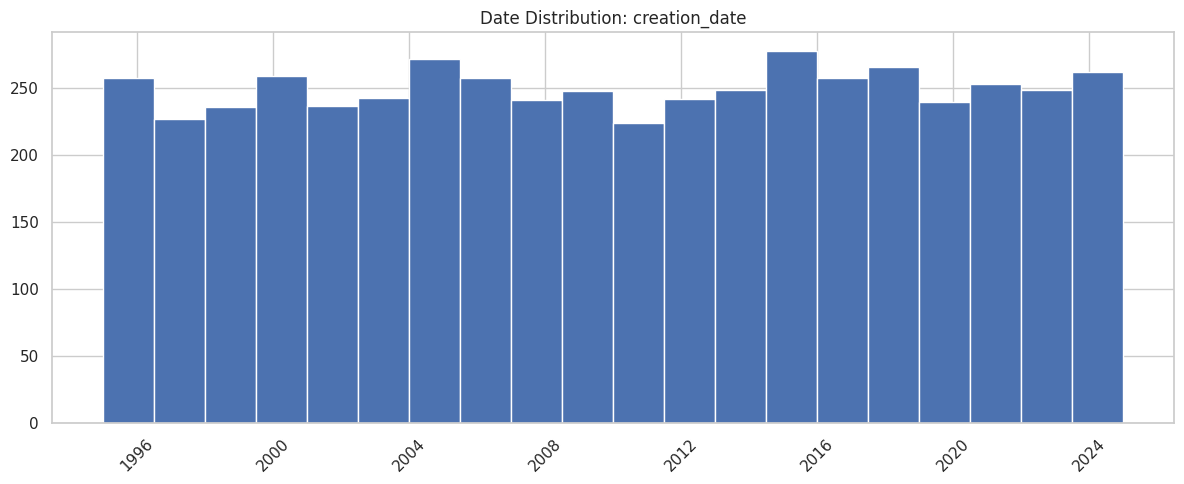

--------------------------------------------------------------------------------

===== COLUMN: branch_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 99
Mean: 50.59, Median: 50.00, Std: 28.50
Skewness: -0.01
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------


In [ ]:
##### Outlier Detection
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_customers = OutlierDetector(cleaned_customers_df)
outlier_results_customers = outlier_detector_customers.analyze_dataframe()
outlier_detector_customers.display_outlier_analysis(outlier_results_customers)


In [ ]:
cleaned_customers_df.columns


Index(['customer_id', 'firstname', 'lastname', 'Age', 'Gender', 'Address',
       'City', 'Contact Number', 'Email', 'creation_date', 'branch_id'],
      dtype='object')


--- PLOTTING EXAMPLES ---



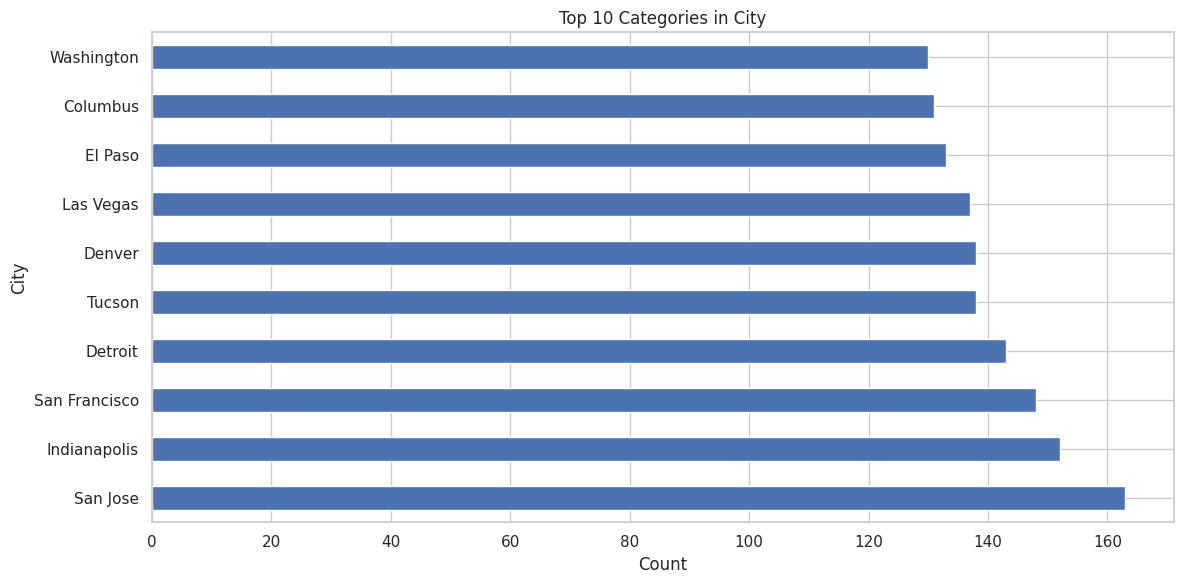

In [ ]:
#### Plotting
print("\n--- PLOTTING EXAMPLES ---\n")
plotter = Plotter(cleaned_customers_df)

# Plot city distribution if available
plotter.plot_categorical_distribution('City', top_n=10)

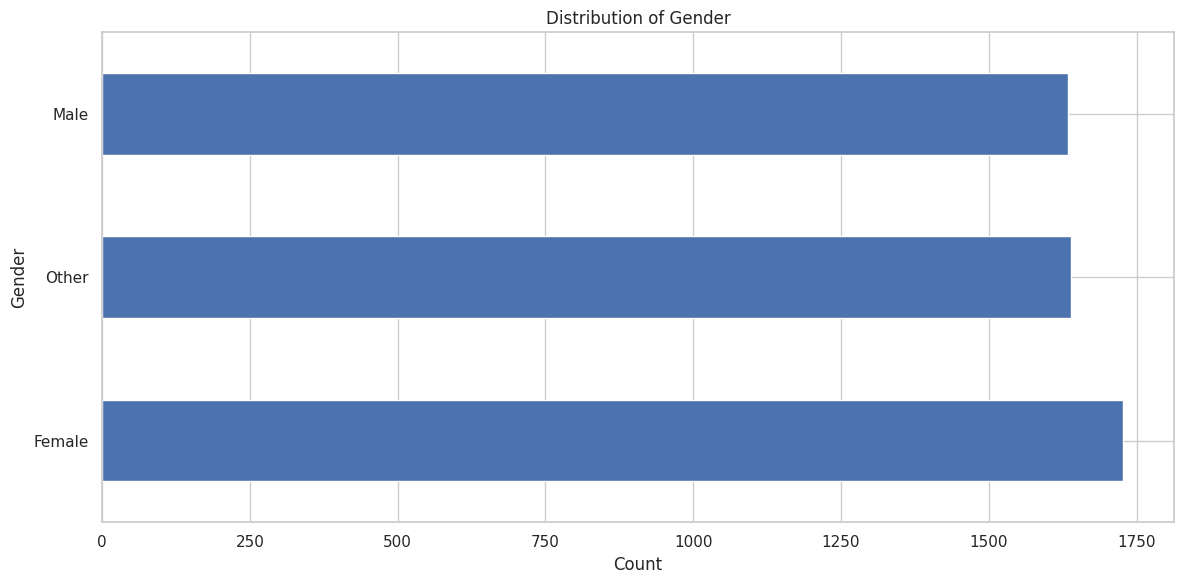

In [ ]:
plotter.plot_categorical_distribution('Gender', top_n=10)

In [ ]:
cleaned_customers_df.groupby(["Address", "City"])["Address"].agg("count").describe()


count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: Address, dtype: float64